# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import urllib.request
import zipfile

from PIL import Image
import io

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Download and Save Dataset

In [38]:
url = 'https://github.com/Griselia23/IC-mur-/archive/refs/heads/main.zip'
#https://github.com/Griselia23/autocounterinko/archive/refs/heads/main.zip

zip_path = 'dataset-resized.zip'
extract_path = 'dataset-resized'

# Download the dataset zip file
urllib.request.urlretrieve(url, zip_path)

# Unzip the downloaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define the new data directory after extraction
data_dir = os.path.join(extract_path, 'IC-mur--main/dataset')

# Create Data Path

In [39]:
# Create a list of filepaths and labels
filepaths = []
labels = []
classlist = os.listdir(data_dir)
for kelass in classlist:
    classpath = os.path.join(data_dir, kelass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(kelass)

# Create a DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

print(df.head())
print(df['labels'].value_counts())

                                          filepaths labels
0  dataset-resized/IC-mur--main/dataset/m10/1 2.jpg    m10
1  dataset-resized/IC-mur--main/dataset/m10/1 5.jpg    m10
2  dataset-resized/IC-mur--main/dataset/m10/1 8.jpg    m10
3  dataset-resized/IC-mur--main/dataset/m10/1 3.jpg    m10
4  dataset-resized/IC-mur--main/dataset/m10/1 6.jpg    m10
labels
m10    13
m8     13
Name: count, dtype: int64


# Data Split

In [40]:
# Splitting data into train, validation, and test sets
train_split = .8
test_split = .1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))


train_df length: 20 test_df length: 3 valid_df length: 3


# Preprocessing

In [41]:
# Preprocessing dataset
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

test batch size: 3 test steps: 1


## Augmentation

In [42]:
#augmentation
gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

Found 20 validated image filenames belonging to 2 classes.
Found 3 validated image filenames belonging to 2 classes.
Found 3 validated image filenames belonging to 2 classes.
['m10', 'm8']


In [43]:
# Image augmentation
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Generate Data

In [69]:
#buat generator untuk train, valid, test
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 20 validated image filenames belonging to 2 classes.
Found 3 validated image filenames belonging to 2 classes.
Found 3 validated image filenames belonging to 2 classes.


## Data Checking

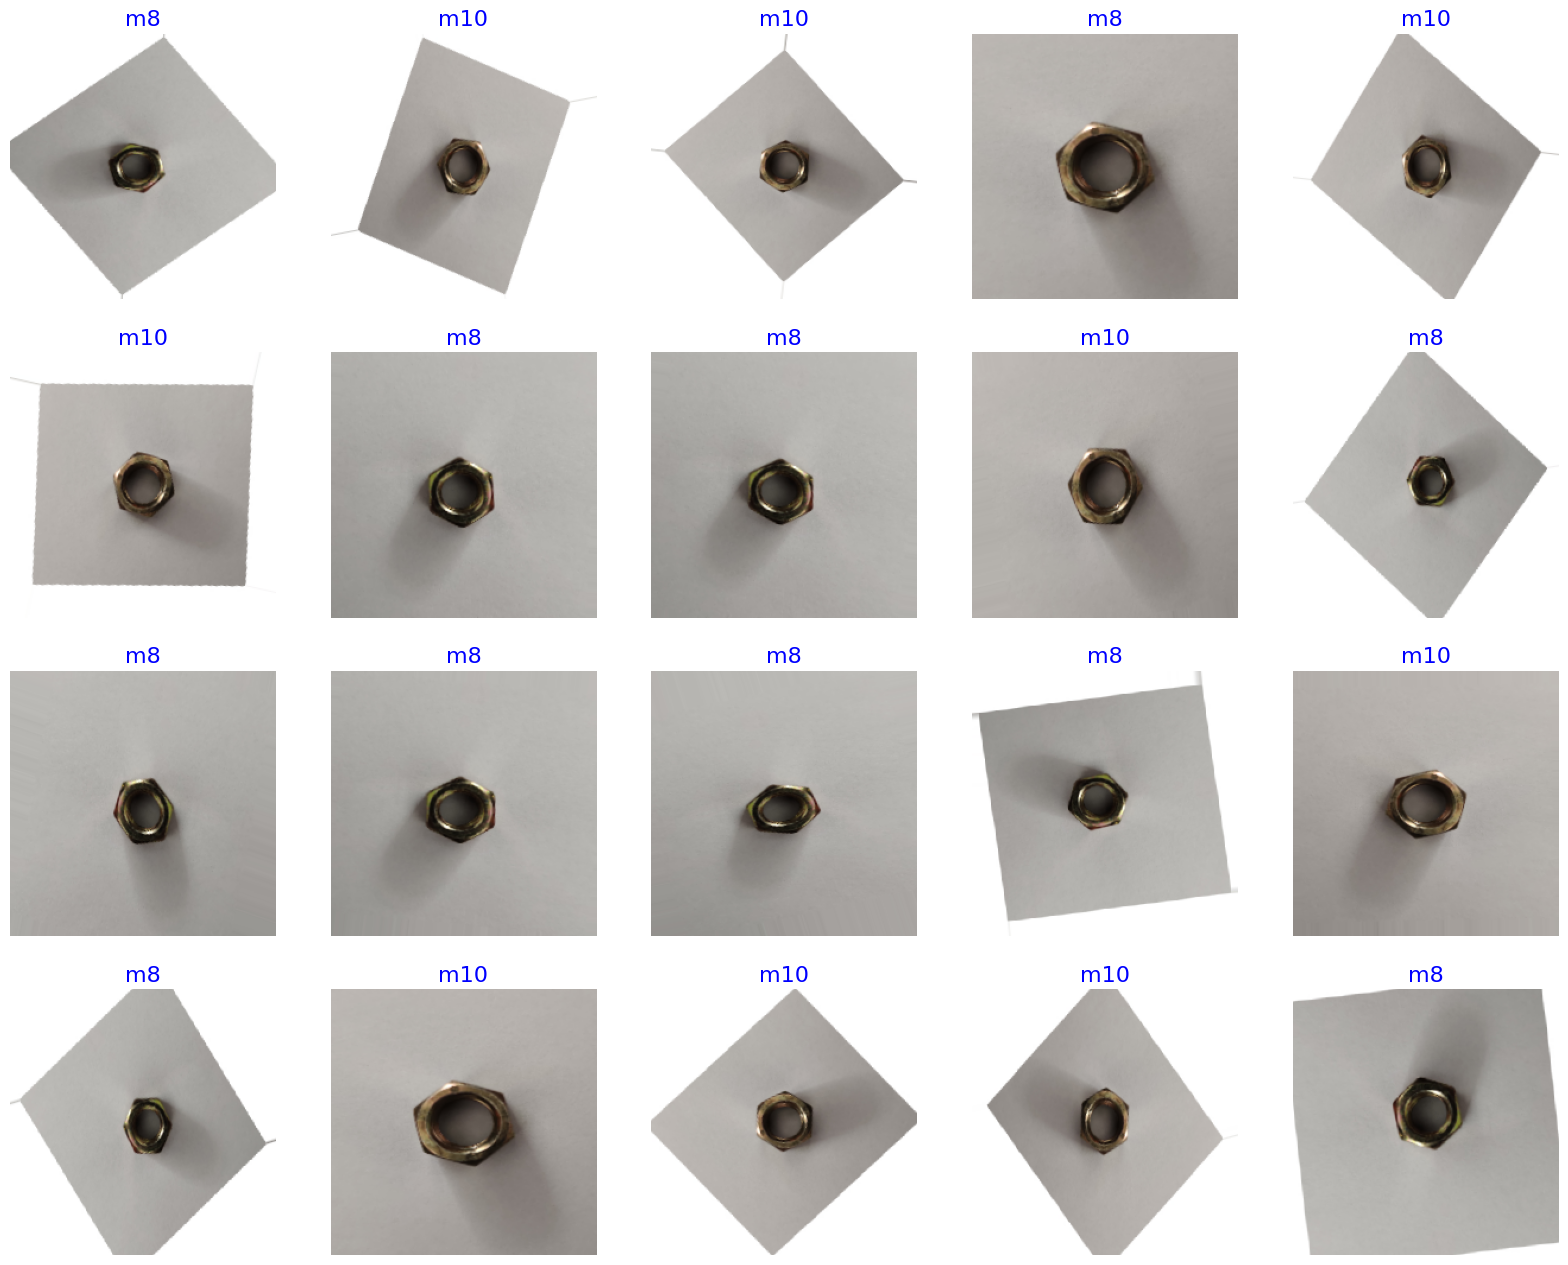

In [70]:
# Visualizing some sample images
def show_image_samples(gen):
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

# Modeling

In [71]:
# Definisiin extractor dan compile model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

# Build the model
model = Sequential([
    extractor,  # Feature extractor
    Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Call build() method to build the model
model.build((None, 224, 224, 3))

# Print model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_23 (Functional)           │ (None, 7, 7, 160)           │       1,364,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 32)            │          46,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,429,602 (5.45 MB)

 Trainable params: 64,738 (252.88 KB)

 Non-trainable params: 1,364,864 (5.21 MB)

# Training

In [72]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping, checkpoint])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5000 - loss: 3.9891 - val_accuracy: 0.0000e+00 - val_loss: 3.6735
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6000 - loss: 1.7849 - val_accuracy: 0.3333 - val_loss: 5.0413
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 2.9486 - val_accuracy: 0.0000e+00 - val_loss: 3.2182
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6500 - loss: 1.4580 - val_accuracy: 0.0000e+00 - val_loss: 1.5031
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7000 - loss: 1.3166 - val_accuracy: 0.6667 - val_loss: 0.9826
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6500 - loss: 1.1350 - val_accuracy: 0.6667 - val_loss: 0.7472
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8000 - loss: 0.7713 - val_accuracy: 0.6667 - val_loss: 0.7203
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5500 - loss: 1.6296 - val_accuracy: 0.0000e+00 - val_loss: 0.8823
Epoch 9/20


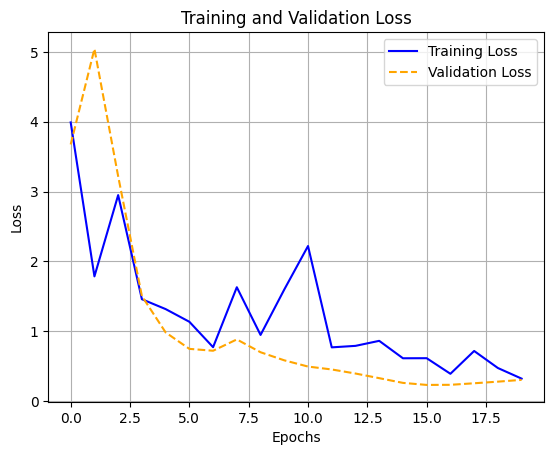

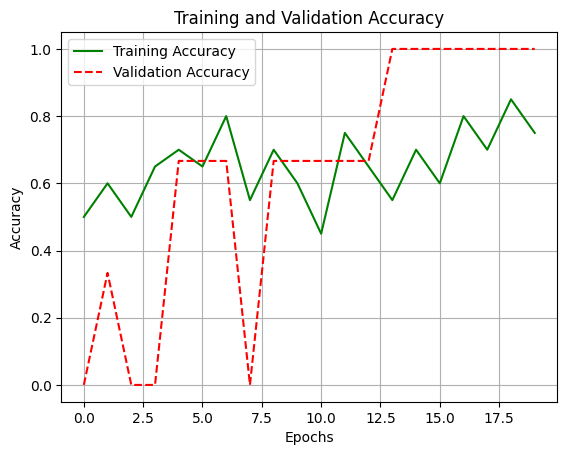

In [74]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Save and Convert Model

In [75]:
model.save('my_model.keras')
model.save('my_model.h5')
model = tf.keras.models.load_model('my_model.h5')
model.save('model_v1.5.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpzaeligi4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_11')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140383120015424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120026864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120028976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120022288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120024576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120030384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120326720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120327600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120031264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120327072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140383120331

# Testing

In [77]:
from tensorflow.keras.preprocessing import image
classes = ["m8","m10" ]


In [78]:
def preprocess_image(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

In [79]:
# Function to predict the class of the image
def predict_image_class(model, img):
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    class_name = classes[predicted_class[0]]
    confidence = np.max(predictions) * 100
    return class_name, confidence

In [80]:
def display_prediction(img, class_name, confidence):
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

In [81]:

import ipywidgets as widgets
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    # Get the uploaded file
    file = next(iter(upload_widget.value.values()))
    content = file['content']

    # Open the image
    img = Image.open(io.BytesIO(content))
    class_name, confidence = predict_image_class(model, img)
    display_prediction(img, class_name, confidence)

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


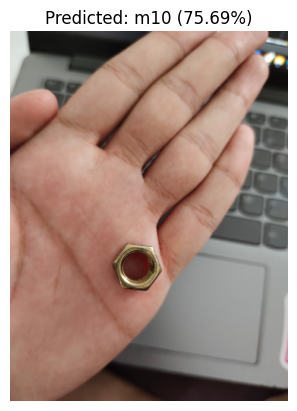

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


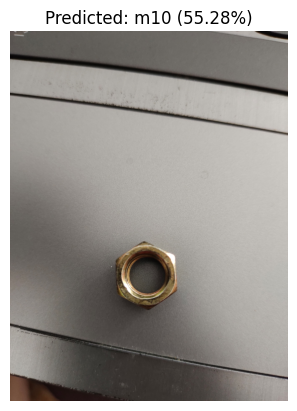

In [82]:
upload_widget.observe(on_upload_change, names='value')

display(upload_widget)

In [68]:
#evaluasi bismillah
test_gen.reset()
predictions = model.predict(test_gen, steps=test_steps, verbose=1)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes

report = classification_report(true_classes, predicted_classes, target_names=classes)
print(report)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

         m10       0.50      0.50      0.50         2
          m8       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3

